In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler
import numpy as np
import pyBigWig
from pyfaidx import Fasta
import pandas as pd
import random
import wandb
import time
from tqdm import tqdm
from scipy.stats import spearmanr
from datetime import timedelta
import os
import concurrent.futures




import sys
sys.path.append("/cluster/home/jjanssens/jjans/software")
sys.path.append("/cluster/home/jjanssens/jjans/software/cross_species_DL")

In [2]:
from cross_species_DL.src.datasets.peak_dataset import PeakDataset
from cross_species_DL.src.datasets.batch_sampling import BalancedBatchSampler, OversamplingBalancedBatchSampler

from cross_species_DL.src.utils.helpers import one_hot_encode,reverse_complement, GradReverse, grad_reverse, split_bed_by_chrom
from cross_species_DL.src.evaluation.eval import evaluate_model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))
    print("Memory available (MB):", round(torch.cuda.get_device_properties(0).total_memory / 1024**2))

Using device: cuda
CUDA device name: Quadro RTX 6000
Memory available (MB): 24023


In [4]:
from cross_species_DL.src.utils.helpers import load_and_filter_bed


In [30]:
import os
celltype = 'Enterocytes'

bed_dict = {}
for species in ['Human','Bonobo','Chimpanzee','Gorilla','Macaque','Marmoset']:
    print(species)
    path_bed = f"/cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/atac/consensus_peak_calling_{species}/MACS/{celltype}_peaks.narrowPeak"
    
    if os.path.exists(path_bed):
        regions_species = load_and_filter_bed(path_bed,qval_threshold=0.15,max_regions=30000)
        print(len(regions_species.index))
        bed_dict[species] = regions_species
    else:
        print(f"Warning: {species} BED file not found → {path_bed}")

Human
30000
Bonobo
30000
Chimpanzee
30000
Gorilla
30000
Macaque
30000
Marmoset
30000


In [58]:
import os

bw_dict = {}
for species in ['Human', 'Bonobo', 'Chimpanzee', 'Gorilla', 'Macaque', 'Marmoset']:
    bw_path = f'bigwigs/{species}_enterocytes.hg38.bw'
    bw_path = f'/cluster/project/treutlein/USERS/jjans/analysis/adult_intestine/atac/consensus_peak_calling_{species}/pseudobulk_bw_files/{celltype}.bw'
    if os.path.exists(bw_path):
        bw_dict[species] = bw_path
    else:
        print(f"⚠️ Missing bigWig for {species}: {bw_path}")

In [38]:
import os
fasta_dict = {
    'Human': '/cluster/home/jjanssens/jjans/analysis/cerebellum/genomes_new/homo_sapiens/hg38.fa.gz',
    'Chimpanzee': '/cluster/home/jjanssens/jjans/data/intestine/nhp_atlas/genomes/reference_/panTro3/fasta/genome.fa',
    'Bonobo': '/cluster/home/jjanssens/jjans/data/intestine/nhp_atlas/genomes/reference_/panPan1/fasta/genome.fa',
    'Gorilla': '/cluster/home/jjanssens/jjans/data/intestine/nhp_atlas/genomes/reference_/gorGor4/fasta/',
    'Macaque': '/cluster/home/jjanssens/jjans/data/intestine/nhp_atlas/genomes/reference_/Mmul10/fasta/genome.fa',
    'Marmoset': '/cluster/home/jjanssens/jjans/data/intestine/nhp_atlas/genomes/reference_/calJac1_mito/fasta/genome.fa',
}

# Check if files exist
for species, path in fasta_dict.items():
    if not os.path.exists(path):
        print(f"⚠️ Missing FASTA for {species}: {path}")

In [39]:
def split_all_species_beds(bed_dict, val_chroms, test_chroms):
    """
    Split each species' BED into train/val/test based on chromosome lists.

    Parameters
    ----------
    bed_dict : dict
        Dictionary with species as keys and BED DataFrames as values.
    val_chroms : list of str
        Chromosomes for validation split.
    test_chroms : list of str
        Chromosomes for test split.

    Returns
    -------
    dict
        Dictionary with structure:
        split_beds[species] = {'train': ..., 'val': ..., 'test': ...}
    """
    split_beds = {}

    for species, bed in bed_dict.items():
        all_chroms = list(set(bed['chr']))
        train_chroms = [ch for ch in all_chroms if ch not in val_chroms + test_chroms]

        print(f"{species} → Train chromosomes: {sorted(train_chroms)}")

        train_bed, val_bed, test_bed = split_bed_by_chrom(
            bed, train_chroms, val_chroms, test_chroms
        )

        split_beds[species] = {
            'train': train_bed,
            'val': val_bed,
            'test': test_bed
        }

    return split_beds

In [41]:
val_chroms = ["chr8", "chr20","8","20"]
test_chroms = ["chr1", "chr3", "chr6","1","3","6"]

split_beds = split_all_species_beds(bed_dict, val_chroms, test_chroms)

# Access example:
human_train = split_beds["Human"]["train"]
chimp_test = split_beds["Chimpanzee"]["test"]

Human → Train chromosomes: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr21', 'chr22', 'chr4', 'chr5', 'chr7', 'chr9', 'chrX', 'chrY']
Bonobo → Train chromosomes: ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '2A', '2B', '4', '5', '7', '9', 'AJFE02000531.1', 'AJFE02000594.1', 'AJFE02000712.1', 'AJFE02001010.1', 'AJFE02001283.1', 'AJFE02001670.1', 'AJFE02002198.1', 'AJFE02002242.1', 'AJFE02002360.1', 'AJFE02002581.1', 'AJFE02002634.1', 'AJFE02002978.1', 'AJFE02003178.1', 'AJFE02003391.1', 'AJFE02003564.1', 'AJFE02003581.1', 'AJFE02003871.1', 'AJFE02003886.1', 'AJFE02003887.1', 'AJFE02004231.1', 'AJFE02004273.1', 'AJFE02004568.1', 'AJFE02004677.1', 'AJFE02005089.1', 'AJFE02005156.1', 'AJFE02005927.1', 'AJFE02006081.1', 'AJFE02006502.1', 'AJFE02006802.1', 'AJFE02006824.1', 'AJFE02007023.1', 'AJFE02007039.1', 'AJFE02007160.1', 'AJFE02007951.1', 'AJFE02008374.1', 'AJFE02009928.1', 'AJFE02010537.1', 'AJFE0201

In [44]:
            bed_splits['val'], bw_path, fa_path,
            label=label, seq_len=seq_len,
            augment=False, validate_regions=True


'Chimpanzee'

In [46]:
bed_splits['val']

chr      start        end     summit
169317  20   17930826   17938823   17934824
169014  20   14324974   14326160   14325567
168812  20    9839734    9841275    9840504
168750  20    8248274    8249031    8248652
168261  20    3704048    3707064    3705556
...     ..        ...        ...        ...
287978   8   81662314   81664859   81663586
289188   8  102962002  102966425  102964213
288339   8   87370151   87373431   87371791
285335   8   28791413   28792720   28792066
287830   8   81103533   81104247   81103890

[1839 rows x 4 columns]

In [61]:
from torch.utils.data import Dataset
import pyBigWig
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pyfaidx import Fasta
from src.utils.helpers import one_hot_encode, reverse_complement
import concurrent.futures
import torch

# ============ Dataset ============
class PeakDataset(Dataset):
    def __init__(self, bed_df, bw_path, fasta_path, label, 
                 seq_len=2000, augment=True, augment_both_strands=False, seed=42, max_shift_size=3,
                 normalize_signal=False, normalization_mode="minmax",
                 global_min=None, global_max=None,
                 global_mean=None, global_std=None, validate_regions=True):

        self.bw = pyBigWig.open(bw_path)
        self.fasta = Fasta(fasta_path)
        self.label = label
        self.seq_len = seq_len
        self.augment = augment
        self.augment_both_strands = augment_both_strands
        self.seed = seed
        self.max_shift_size = max_shift_size
        self.normalize_signal = normalize_signal
        self.normalization_mode = normalization_mode
        self.global_min = global_min
        self.global_max = global_max
        self.global_mean = global_mean
        self.global_std = global_std

        self.bed = bed_df.reset_index(drop=True)
        self.bed = self._filter_valid_regions()

        self.bad_indices = set()
        self.skip_bad = True  # Whether to auto-skip broken indices
        if validate_regions:
            self._find_and_store_bad_indices(verbose=True) # Automatically scan on init

    def __len__(self):
        return len(self.bed) * (2 if self.augment and self.augment_both_strands else 1)

    def _standardize_chrom(self, chrom):
        chrom_bw = self.bw.chroms()
        chrom_fa = self.fasta.keys()

        if chrom in chrom_bw and chrom in chrom_fa:
            return chrom
        if chrom.startswith("chr"):
            alt = chrom[3:]
        else:
            alt = f"chr{chrom}"

        if alt in chrom_bw and alt in chrom_fa:
            return alt
        elif chrom in chrom_bw and alt in chrom_fa:
            return chrom
        elif alt in chrom_bw and chrom in chrom_fa:
            return alt
        else:
            raise ValueError(f"Chromosome '{chrom}' not found in both bigWig and FASTA")

    def _filter_valid_regions(self):
        chroms_in_bw = self.bw.chroms()
        chroms_set = set(chroms_in_bw.keys())

        df = self.bed.copy()

        def standardize(chrom):
            try:
                return self._standardize_chrom(chrom)
            except ValueError:
                return None

        df['chrom'] = df['chr'].map(standardize)
        df = df.dropna(subset=['chrom'])

        df['summit'] = df['summit'].astype(int)
        df['start'] = df['summit'] - self.seq_len // 2
        df['end'] = df['summit'] + self.seq_len // 2

        chrom_len_map = pd.Series(chroms_in_bw)
        df['chrom_len'] = df['chrom'].map(chrom_len_map)

        valid = (df['start'] >= 0) & (df['end'] <= df['chrom_len']) & ((df['end'] - df['start']) == self.seq_len)
        n_removed = (~valid).sum()
        df = df[valid].reset_index(drop=True)

        print(f"[PeakDataset] Loaded {len(df)} valid regions. Removed {n_removed} regions that were too close to chromosome edges.")
        return df

    def _find_and_store_bad_indices(self, verbose=True):
        self.bad_indices = set()
        for idx in tqdm(range(len(self))):
            try:
                _ = self.__getitem__(idx)
            except Exception as e:
                if verbose:
                    print(f"[BAD] idx {idx} failed: {e}")
                self.bad_indices.add(idx)
        print(f"[PeakDataset] Found {len(self.bad_indices)} bad indices.")

    def __getitem__(self, idx):
        if self.skip_bad and idx in self.bad_indices:
            return self.__getitem__((idx + 1) % len(self))

        try:
            if self.augment and self.augment_both_strands:
                orig_idx = idx // 2
                is_reverse = idx % 2 == 1
            else:
                orig_idx = idx
                is_reverse = self.augment and random.random() < 0.5

            row = self.bed.iloc[orig_idx]
            chrom = self._standardize_chrom(row['chr'])
            summit = int(row['summit'])

            shift = random.randint(-self.max_shift_size, self.max_shift_size) if self.augment else 0
            start = summit + shift - self.seq_len // 2
            end = summit + shift + self.seq_len // 2

            chrom_len = self.bw.chroms(chrom)
            start = max(0, start)
            end = min(end, chrom_len)

            if end - start != self.seq_len:
                raise ValueError(f"[IDX {idx}] Region length not {self.seq_len} after clipping: {chrom}:{start}-{end}")

            seq = self.fasta[chrom][start:end].seq
            if len(seq) != self.seq_len:
                raise ValueError(f"[IDX {idx}] Extracted sequence length {len(seq)} != expected {self.seq_len} at {chrom}:{start}-{end}")

            if is_reverse:
                seq = reverse_complement(seq)
            x = one_hot_encode(seq)

            signal = self.bw.values(chrom, start, end)
            signal = np.nan_to_num(np.array(signal, dtype=np.float32))

            if self.normalize_signal:
                if self.normalization_mode == "minmax":
                    if self.global_min is None or self.global_max is None:
                        raise ValueError("Global min and max must be provided for min-max normalization.")
                    signal = (signal - self.global_min) / (self.global_max - self.global_min)
                    signal = np.clip(signal, 0, 1)
                elif self.normalization_mode == "zscore":
                    if self.global_mean is None or self.global_std is None:
                        raise ValueError("Global mean and std must be provided for z-score normalization.")
                    signal = (signal - self.global_mean) / self.global_std
                else:
                    raise ValueError(f"Unsupported normalization mode: {self.normalization_mode}")

            y_reg = np.mean(signal, dtype=np.float32)

            return (
                torch.tensor(x, dtype=torch.float32).permute(1, 0),
                torch.tensor(y_reg, dtype=torch.float32).unsqueeze(0),
                torch.tensor(self.label, dtype=torch.float32)
            )

        except Exception as e:
            if self.skip_bad:
                print(f"[Skipping idx {idx}] Reason: {e}")
                self.bad_indices.add(idx)
                return self.__getitem__((idx + 1) % len(self))
            else:
                raise

In [63]:
# Create consistent label mapping: Human → 0, Bonobo → 1, etc.
species_list = sorted(split_beds.keys())
species_labels = {species: i for i, species in enumerate(species_list)}

# Print for reference
print("Species class labels:")
for species, label in species_labels.items():
    print(f"{species}: {label}")

# Set sequence length
seq_len = 2114

# Create datasets
dataset_dict = {}

for species in species_list:
    bed_splits = split_beds[species]
    bw_path = bw_dict.get(species)
    fa_path = fasta_dict.get(species)
    label = species_labels[species]

    if not bw_path or not fa_path:
        print(f"⚠️ Missing data for {species} — skipping dataset creation")
        continue

    dataset_dict[species] = {
        'train': PeakDataset(
            bed_splits['train'], bw_path, fa_path,
            label=label, seq_len=seq_len,
            augment=True, augment_both_strands=True,
            max_shift_size=5, seed=42, validate_regions=True
        ),
        'val': PeakDataset(
            bed_splits['val'], bw_path, fa_path,
            label=label, seq_len=seq_len,
            augment=False, validate_regions=True
        ),
        'test': PeakDataset(
            bed_splits['test'], bw_path, fa_path,
            label=label, seq_len=seq_len,
            augment=False, validate_regions=True
        )
    }

Species class labels:
Bonobo: 0
Chimpanzee: 1
Gorilla: 2
Human: 3
Macaque: 4
Marmoset: 5
[PeakDataset] Loaded 21700 valid regions. Removed 105 regions that were too close to chromosome edges.


100%|██████████| 43400/43400 [03:28<00:00, 207.93it/s]


[PeakDataset] Found 0 bad indices.
[PeakDataset] Loaded 1565 valid regions. Removed 1 regions that were too close to chromosome edges.


100%|██████████| 1565/1565 [00:19<00:00, 79.74it/s] 


[PeakDataset] Found 0 bad indices.
[PeakDataset] Loaded 6629 valid regions. Removed 0 regions that were too close to chromosome edges.


100%|██████████| 6629/6629 [01:30<00:00, 73.45it/s] 


[PeakDataset] Found 0 bad indices.
[PeakDataset] Loaded 21369 valid regions. Removed 23 regions that were too close to chromosome edges.


100%|██████████| 42738/42738 [15:17<00:00, 46.59it/s]


[PeakDataset] Found 0 bad indices.
[PeakDataset] Loaded 1839 valid regions. Removed 0 regions that were too close to chromosome edges.


100%|██████████| 1839/1839 [00:46<00:00, 39.57it/s]


[PeakDataset] Found 0 bad indices.
[PeakDataset] Loaded 6769 valid regions. Removed 0 regions that were too close to chromosome edges.


 29%|██▊       | 1934/6769 [02:10<02:38, 30.55it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [64]:
from cross_species_DL.src.models.residual_dilated_cnn import ResidualDilatedCNN
from cross_species_DL.src.training.train_model_flexamp import train_model_flexible_AMP

In [65]:
signal_stats = {}

for species, splits in dataset_dict.items():
    train_ds = splits.get('train')

    if train_ds is None:
        print(f"⚠️ No training dataset for {species}, skipping...")
        continue

    print(f"▶️ Sampling signal from: {species}")
    
    # Estimate distribution
    signal_values, stats = train_ds.sample_signal_distribution()
    
    # Compute robust min/max
    min_val, max_val = train_ds.compute_signal_min_max()

    # Store results
    signal_stats[species] = {
        'min': min_val,
        'max': max_val,
        'mean': stats['mean'],
        'std': stats['std'],
        **stats
    }

    print(f"  ↳ min={min_val:.4f}, max={max_val:.4f}, mean={stats['mean']:.4f}, std={stats['std']:.4f}")

▶️ Sampling signal from: Bonobo


AttributeError: 'PeakDataset' object has no attribute 'sample_signal_distribution'

In [66]:
train_ds.

In [17]:
ds_chimp_test.sample_signal_distribution()

(array([0.05272426, 0.05272426, 0.05272426, ..., 0.10544852, 0.10544852,
        0.10544852], dtype=float32),
 {'mean': 0.4515257775783539,
  'std': 0.3477538228034973,
  'p1': 0.052724260836839676,
  'p25': 0.2108970433473587,
  'p50': 0.3690698444843292,
  'p75': 0.6326911449432373,
  'p99': 1.370830774307251})

In [18]:
# STEP 2: Compute min-max stats per species from train data
human_min, human_max = ds_human_train.compute_signal_min_max()
chimp_min, chimp_max = ds_chimp_train.compute_signal_min_max()

In [19]:
human_min, human_max = 0.055166829377412796, 1.048169732093811
chimp_min, chimp_max = 0.052724260836839676, 1.370830774307251

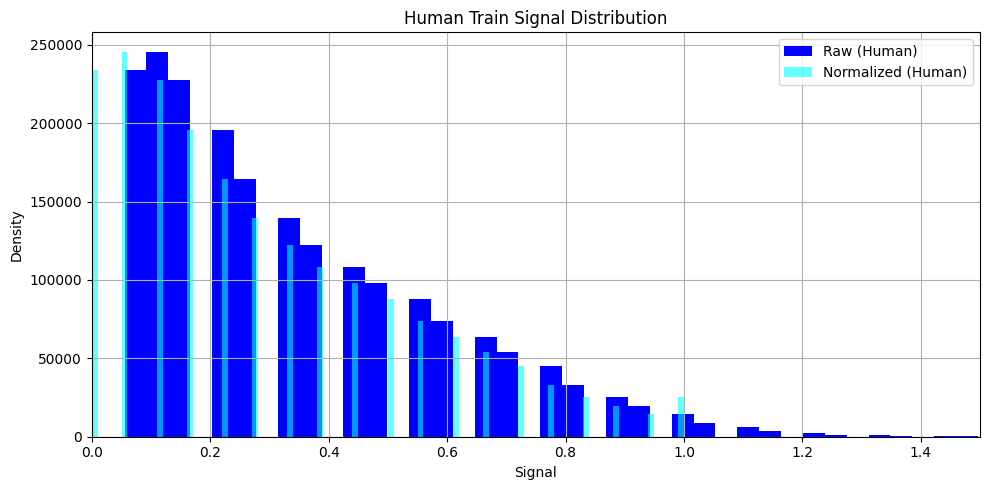

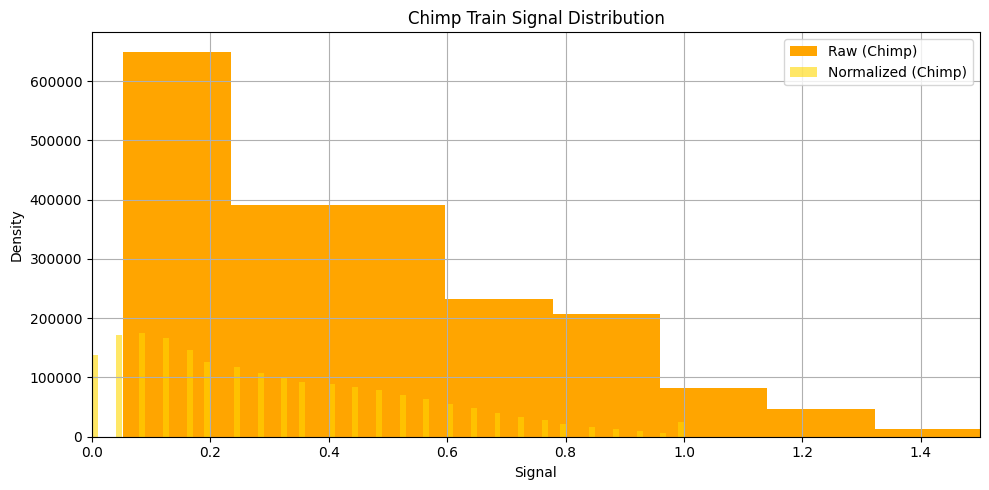

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def normalize(values, global_min, global_max):
    return np.clip((values - global_min) / (global_max - global_min), 0, 1)

# Sample and plot raw + normalized signals for HUMAN train
human_raw, human_stats = ds_human_train.sample_signal_distribution()
human_norm = normalize(human_raw, human_min, human_max)

plt.figure(figsize=(10, 5))
#sns.histplot(human_raw, stat='density', label='Raw (Human)', color='blue')
#sns.histplot(human_norm, stat='density', label='Normalized (Human)', color='cyan')
plt.hist(human_raw, bins=100, label='Raw (Human)',color='blue')
plt.hist(human_norm, bins=100, label='Normalized (Human)',color='cyan',alpha=0.6)

plt.title("Human Train Signal Distribution")
plt.xlabel("Signal")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim([0,1.5])
plt.show()

# Sample and plot raw + normalized signals for CHIMP train
chimp_raw, chimp_stats = ds_chimp_train.sample_signal_distribution()
chimp_norm = normalize(chimp_raw, chimp_min, chimp_max)

plt.figure(figsize=(10, 5))
#sns.histplot(chimp_raw,bins=100, stat='density', label='Raw (Chimp)', color='orange')
#sns.histplot(chimp_norm,bins=100, stat='density', label='Normalized (Chimp)', color='gold')
plt.hist(chimp_raw,bins=100, label='Raw (Chimp)',color='orange')
plt.hist(chimp_norm,bins=100, label='Normalized (Chimp)',color='gold',alpha=0.6)
plt.title("Chimp Train Signal Distribution")
plt.xlabel("Signal")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim([0,1.5])
plt.show()

In [21]:
# STEP 3: Apply normalization to ALL datasets
datasets = {
    "train": [ds_human_train, ds_chimp_train],
    "val":   [ds_human_val, ds_chimp_val],
    "test":  [ds_human_test, ds_chimp_test],
}

# Human datasets
for ds in [ds_human_train, ds_human_val, ds_human_test]:
    ds.global_min = human_min
    ds.global_max = human_max
    ds.normalize_signal = True
    ds.normalization_mode = "minmax"

# Chimp datasets
for ds in [ds_chimp_train, ds_chimp_val, ds_chimp_test]:
    ds.global_min = chimp_min
    ds.global_max = chimp_max
    ds.normalize_signal = True
    ds.normalization_mode = "minmax"

In [22]:
#Concatenate genomes
from torch.utils.data import ConcatDataset

# Training
train_ds = ConcatDataset([ds_human_train, ds_chimp_train])
sampler = BalancedBatchSampler([len(ds_human_train), len(ds_chimp_train)], batch_size=128,seed=42)
train_loader = DataLoader(train_ds, batch_sampler=sampler)

# Validation
val_ds = ConcatDataset([ds_human_val, ds_chimp_val])
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# Test
test_ds = ConcatDataset([ds_human_test, ds_chimp_test])
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)


In [23]:
model = ResidualDilatedCNN()

train_model_flexible_AMP(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    project_name="species_test_debug",
    epochs=50,
    patience=3,
    lr=1e-3,
    min_lr=1e-6,
    checkpoint_subdir="human_vs_chimp_cluster1",
    reg_loss_weight=1,
    clf_loss_weight=1,  # single-head regression
    weight_decay=1e-5,
    optimizer_choice="AdamW",
    log_every_n_batches=50,
    use_cosine_scheduler=True,use_cosine_log_mse=True
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jasperjanssens5 (quadbio). Use `wandb login --relogin` to force relogin


Epoch 1 [Val]: 100%|██████████| 60/60 [00:39<00:00,  1.53it/s]


Epoch 1: Train Loss=0.0429, Val Loss=0.0543, Acc=0.4308, Corr=0.7735, Train Acc=0.5000, Train Corr=0.6688, Time=631.94s, ETA=8:36:05


Epoch 2 [Val]: 100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Epoch 2: Train Loss=-0.0398, Val Loss=0.0086, Acc=0.4308, Corr=0.8133, Train Acc=0.5000, Train Corr=0.7223, Time=461.10s, ETA=7:17:16


Epoch 3 [Val]: 100%|██████████| 60/60 [00:14<00:00,  4.01it/s]


Epoch 3: Train Loss=-0.0501, Val Loss=0.0843, Acc=0.4308, Corr=0.8113, Train Acc=0.5000, Train Corr=0.7334, Time=459.33s, ETA=6:45:24


Epoch 4 [Val]: 100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Epoch 4: Train Loss=-0.0579, Val Loss=-0.0324, Acc=0.4308, Corr=0.8191, Train Acc=0.5000, Train Corr=0.7430, Time=459.04s, ETA=6:25:34


Epoch 5 [Val]: 100%|██████████| 60/60 [00:14<00:00,  4.02it/s]


Epoch 5: Train Loss=-0.0643, Val Loss=-0.0224, Acc=0.4308, Corr=0.8215, Train Acc=0.5000, Train Corr=0.7504, Time=459.09s, ETA=6:10:38


Epoch 6 [Val]: 100%|██████████| 60/60 [00:14<00:00,  4.03it/s]


Epoch 6: Train Loss=-0.0686, Val Loss=0.1546, Acc=0.4308, Corr=0.8259, Train Acc=0.5000, Train Corr=0.7553, Time=458.39s, ETA=5:58:01


Epoch 7 [Val]: 100%|██████████| 60/60 [00:14<00:00,  4.04it/s]

Epoch 7: Train Loss=-0.0737, Val Loss=0.0387, Acc=0.4308, Corr=0.8240, Train Acc=0.5000, Train Corr=0.7609, Time=458.70s, ETA=5:46:52
Early stopping triggered.


In [29]:
from cross_species_DL.src.evaluation.eval import evaluate_model
import matplotlib as mpl
import matplotlib.pyplot as plt

Evaluating: 100%|██████████| 672/672 [02:11<00:00,  5.11it/s]

Test Spearman correlation (regression): 0.824
Test Accuracy (classification): 0.000


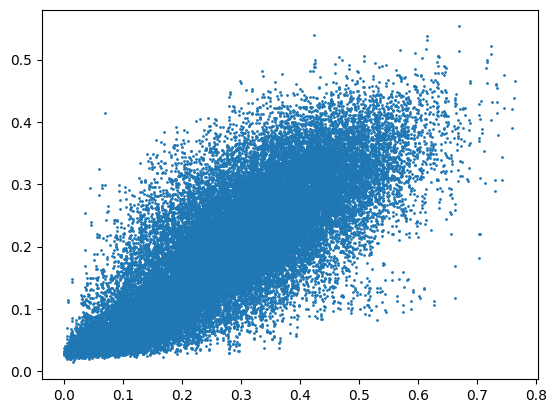

In [43]:
test_loader = DataLoader(ds_human_train, batch_size=64)
a2,b2,c2,d2 = evaluate_model(model, test_loader,return_vals=True,regression=True, classification=True, num_classes=2)

plt.scatter(a2,b2,s=1)
plt.show()

Evaluating: 100%|██████████| 106/106 [00:20<00:00,  5.18it/s]

Test Spearman correlation (regression): 0.835
Test Accuracy (classification): 0.000


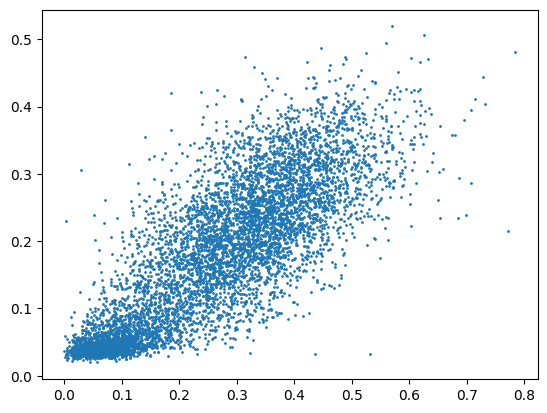

In [42]:
test_loader = DataLoader(ds_human_test, batch_size=64)
a2,b2,c2,d2 = evaluate_model(model, test_loader,return_vals=True,regression=True, classification=True, num_classes=2)

plt.scatter(a2,b2,s=1)
plt.show()

Evaluating: 100%|██████████| 576/576 [05:06<00:00,  1.88it/s]

Test Spearman correlation (regression): 0.781
Test Accuracy (classification): 1.000


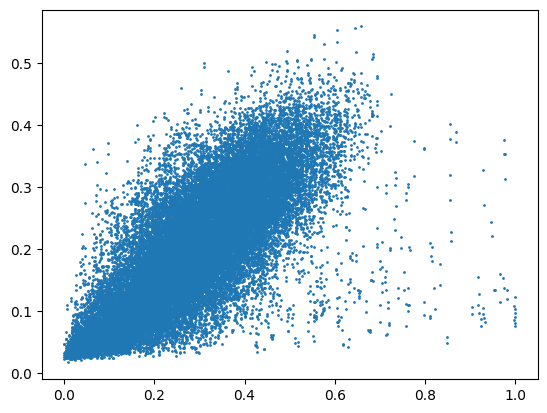

In [45]:
test_loader = DataLoader(ds_chimp_train, batch_size=64)
a2,b2,c2,d2 = evaluate_model(model, test_loader,return_vals=True,regression=True, classification=True, num_classes=2)
plt.scatter(a2,b2,s=1)
plt.show()

Evaluating: 100%|██████████| 85/85 [01:20<00:00,  1.06it/s]

Test Spearman correlation (regression): 0.793
Test Accuracy (classification): 1.000


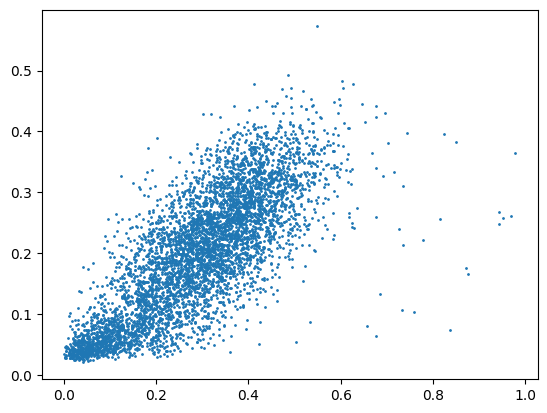

In [46]:
test_loader = DataLoader(ds_chimp_test, batch_size=64)
a2,b2,c2,d2 = evaluate_model(model, test_loader,return_vals=True,regression=True, classification=True, num_classes=2)
plt.scatter(a2,b2,s=1)
plt.show()

In [ ]:
!ls checkpoints/human_vs_chimp_cluster1

In [ ]:
model.save('checkpoints/human_vs_chimp_cluster1/best_model_final.pt')

model2 = ResidualDilatedCNN.load('checkpoints/human_vs_chimp_cluster1/best_model_final.pt')

In [42]:
# ======= EXPLAINABILITY FUNCTIONS IN PURE PYTORCH =======
import torch
import torch.nn.functional as F
import numpy as np

# ============ Saliency Map ============
def compute_saliency_map(model, x, target_class=None):
    """
    Computes saliency map: gradient of output w.r.t input * input.
    Input:
        x: (1, 4, L) torch tensor (requires_grad will be set)
    Output:
        saliency: (1, 4, L) numpy array
    """
    x = x.clone().detach().requires_grad_(True)
    model.eval()

    output_reg, output_clf = model(x)
    if target_class == 'regression':
        target = output_reg
    elif target_class == 'classification':
        target = output_clf
    else:
        target = output_clf  # default

    target.backward(torch.ones_like(target))
    saliency = x.grad * x  # Gradient x Input
    return saliency.detach().cpu().numpy()

# ============ Integrated Gradients ============
def integrated_gradients(model, x, baseline=None, target_class='classification', steps=50):
    """
    Integrated gradients attribution.
    x: (1, 4, L) input
    baseline: (1, 4, L) baseline input (e.g., zeros)
    """
    if baseline is None:
        baseline = torch.zeros_like(x)
    assert x.shape == baseline.shape

    # Generate scaled inputs
    scaled_inputs = [baseline + (float(i) / steps) * (x - baseline) for i in range(steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)  # (steps+1, 4, L)

    scaled_inputs.requires_grad = True
    model.eval()
    outputs = []
    for input_step in scaled_inputs:
        input_step = input_step.unsqueeze(0)
        input_step.requires_grad_(True)
        out_reg, out_clf = model(input_step)
        if target_class == 'regression':
            out = out_reg
        else:
            out = out_clf
        outputs.append(out)
    outputs = torch.cat(outputs)

    total_gradients = torch.autograd.grad(outputs.sum(), scaled_inputs)[0]  # (steps+1, 4, L)
    avg_grads = (total_gradients[:-1] + total_gradients[1:]) / 2.0  # trapezoidal rule
    integrated_grads = (x - baseline).squeeze(0) * avg_grads.mean(dim=0)
    return integrated_grads.detach().cpu().numpy()

# ============ Mutagenesis ============
def in_silico_mutagenesis(model, x, target_class='classification', batch_size=128):
    """
    In silico mutagenesis.
    x: (1, 4, L) one-hot input sequence
    """
    x = x.clone().detach()
    model.eval()
    B, C, L = x.shape
    ref_pred = model(x)[1 if target_class == 'classification' else 0].item()

    # Generate all mutations: for each position and for each nucleotide
    all_mut_seqs = []
    for pos in range(L):
        for base in range(C):
            if x[0, base, pos] == 1:
                continue  # skip wildtype
            mut = x.clone()
            mut[0, :, pos] = 0
            mut[0, base, pos] = 1
            all_mut_seqs.append(mut.clone())

    all_mut_seqs = torch.cat(all_mut_seqs, dim=0)

    preds = []
    for i in range(0, all_mut_seqs.size(0), batch_size):
        batch = all_mut_seqs[i:i+batch_size]
        with torch.no_grad():
            out_reg, out_clf = model(batch)
            out = out_clf if target_class == 'classification' else out_reg
            preds.extend(out.cpu().numpy())

    mut_scores = np.array(preds).reshape(L, C-1)  # shape: (L, 3)
    # Map back to full array with wildtype as 0 delta
    full_scores = np.zeros((L, C))
    k = 0
    for pos in range(L):
        wt_idx = x[0, :, pos].argmax().item()
        b = 0
        for base in range(C):
            if base == wt_idx:
                continue
            full_scores[pos, base] = preds[k] - ref_pred
            k += 1
    return full_scores.T  # shape: (4, L)

# You can now import these into your model script and use them with:
# - compute_saliency_map(model, input_tensor)
# - integrated_gradients(model, input_tensor)
# - in_silico_mutagenesis(model, input_tensor)
# where input_tensor is of shape (1, 4, L) with torch.float32 and requires_grad where needed.


In [ ]:
model.save('checkpoints/human_vs_chimp_cluster1/best_model_final.pt')

model2 = ResidualDilatedCNN.load('checkpoints/human_vs_chimp_cluster1/best_model_final.pt')

In [65]:
def compute_saliency_map(model, input_tensor, target='regression'):
    """
    Computes saliency map using gradient × input method.

    Args:
        model (nn.Module): Trained PyTorch model.
        input_tensor (torch.Tensor): One-hot encoded input of shape (1, 4, L).
        target (str): 'regression' or 'classification'.

    Returns:
        torch.Tensor: Saliency scores of shape (1, 4, L)
    """
    model.eval()
    device = next(model.parameters()).device
    input_tensor = input_tensor.clone().detach().to(device).requires_grad_(True)

    # Forward pass
    output_reg, output_clf = model(input_tensor)

    if target == 'regression':
        output = output_reg
    elif target == 'classification':
        output = output_clf
    else:
        raise ValueError("target must be 'regression' or 'classification'")

    # Backward pass
    model.zero_grad()
    output.backward(retain_graph=True)

    saliency = input_tensor.grad * input_tensor
    return saliency.detach()

In [117]:
a2_series.sort_values(ascending=False).head(n=10).index

Index([1879, 2410, 2440, 2435, 1130, 2313, 2438, 873, 2439, 664], dtype='int64')

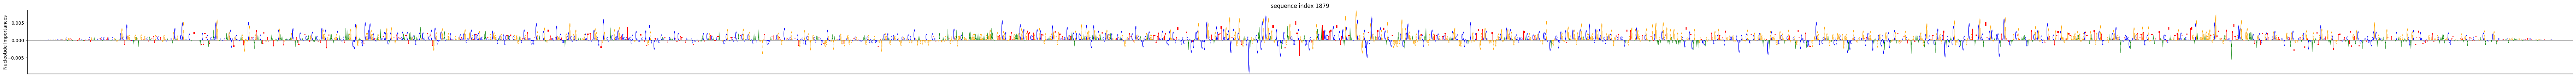

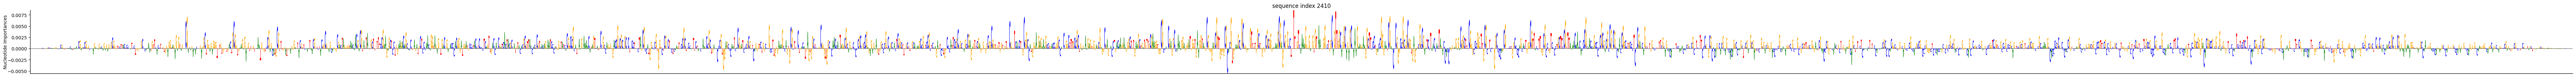

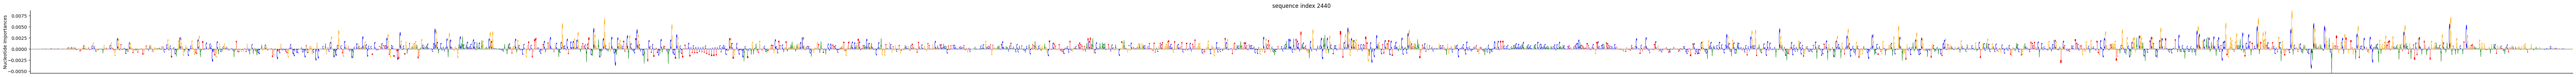

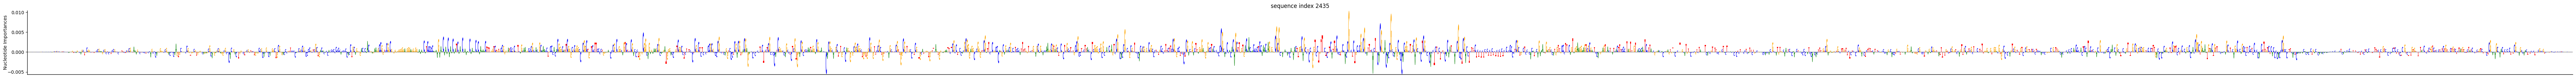

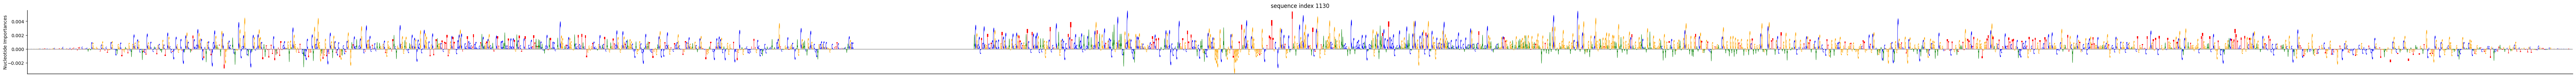

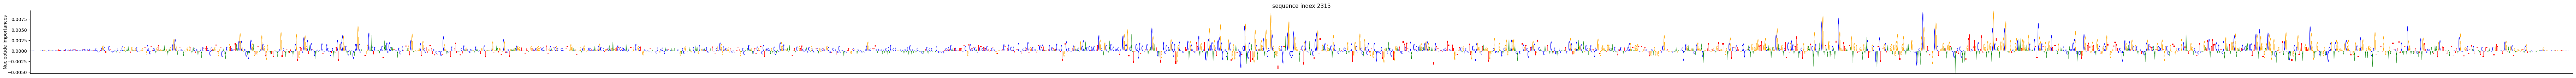

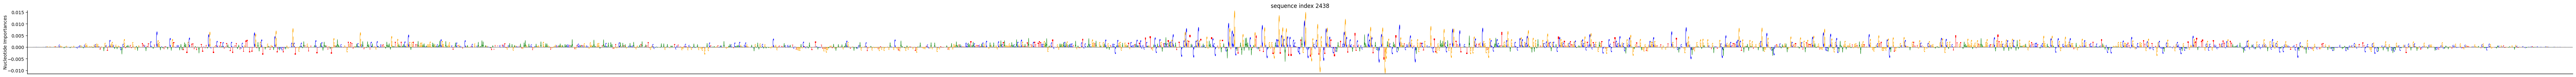

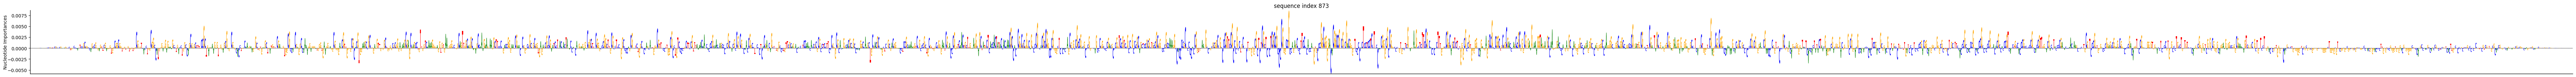

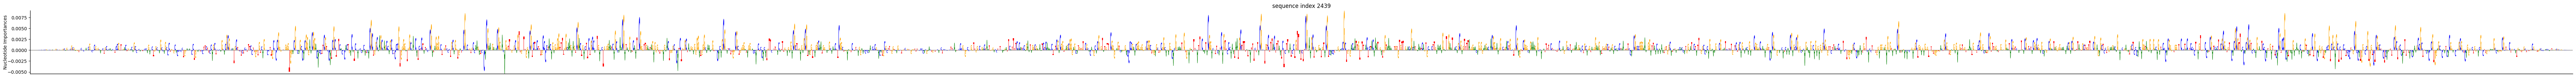

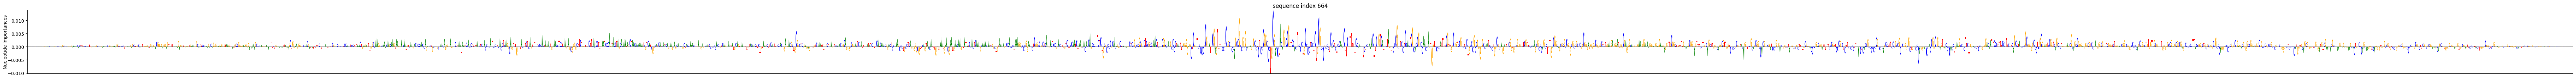

In [118]:
for i in [1879, 2410, 2440, 2435, 1130, 2313, 2438, 873, 2439, 664]:
    x = ds_chimp_test[i][0]
    x = x.unsqueeze(0)  # shape: (1, 4, L)
    saliency = compute_saliency_map(model2, x, target='regression')  # or target='clf'

    expl = x.cpu()*saliency.cpu()
    expl = pd.DataFrame(expl[0])
    expl = expl.T
    expl.columns = ['A','C','G','T']
    seq_df = expl

    # create Logo object
    import logomaker
    
    crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                              shade_below=0,
                              fade_below=0)
    
    # style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    #crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    crp_logo.ax.set_xticks([])
    
    # style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    plt.title("sequence index "+str(i))
    #plt.xticks(ticks=tick_locations,labels = rounded_grid2)
    #plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".png",dpi=350,bbox_inches='tight',pad_inches=0)
    #plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)
    
    plt.show()
    plt.close()

In [119]:
import torch
import numpy as np

def expected_integrated_grad(
    model: torch.nn.Module,
    x: torch.Tensor,  # shape: (1, 4, L)
    target: str = "reg",  # "reg" or "clf"
    num_baselines: int = 10,
    num_steps: int = 20,
    device: str = "cuda"
) -> torch.Tensor:
    """
    Compute Expected Integrated Gradients for a 1D sequence input.

    Args:
        model: trained PyTorch model
        x: one-hot encoded input of shape (1, 4, L)
        target: which output to use ("reg" or "clf")
        num_baselines: how many random shuffles as baselines
        num_steps: how many integration steps
        device: "cuda" or "cpu"

    Returns:
        Attributions of shape (1, 4, L)
    """
    model.eval()
    x = x.to(device).requires_grad_()
    B, C, L = x.shape

    # Generate shuffled baselines
    baselines = []
    x_np = x.detach().cpu().numpy()[0]  # shape (4, L)
    for _ in range(num_baselines):
        shuffled = x_np[:, np.random.permutation(L)]
        baselines.append(torch.tensor(shuffled, dtype=torch.float32, device=device))
    baselines = torch.stack(baselines)  # (B', 4, L)

    # Integration steps
    steps = torch.linspace(0, 1, num_steps + 1, device=device).view(-1, 1, 1, 1)  # (S, 1, 1, 1)

    grads = []

    for baseline in baselines:
        baseline = baseline.unsqueeze(0).expand_as(x)  # (1, 4, L)
        interpolated = baseline + steps * (x - baseline)  # (S, 1, 4, L)
        interpolated = interpolated.squeeze(1).requires_grad_()  # (S, 4, L)

        preds = []
        for i in range(num_steps + 1):
            inp = interpolated[i:i+1]  # shape (1, 4, L)
            inp.requires_grad_()
            out_reg, out_clf = model(inp)
            output = out_reg if target == "reg" else out_clf
            grad = torch.autograd.grad(output.sum(), inp)[0]  # shape (1, 4, L)
            preds.append(grad)

        grads.append(torch.stack(preds))  # shape: (S+1, 1, 4, L)

    grads = torch.stack(grads)  # (B', S+1, 1, 4, L)
    avg_grads = (grads[:, :-1] + grads[:, 1:]) / 2.0  # trapezoidal approx
    avg_grads = avg_grads.mean(dim=1)  # mean over steps → shape (B', 1, 4, L)
    avg_grads = avg_grads.mean(dim=0)  # mean over baselines → shape (1, 4, L)

    # Multiply by (x - baseline_mean)
    baseline_mean = baselines.mean(dim=0, keepdim=True)  # (1, 4, L)
    attributions = (x - baseline_mean) * avg_grads  # (1, 4, L)

    return attributions.detach()

In [121]:
saliency_eig = expected_integrated_grad(model2, x, target="reg")

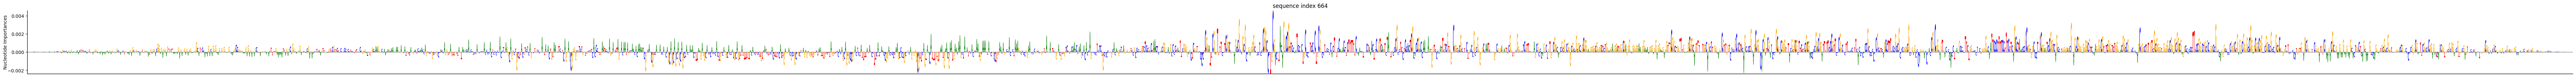

In [122]:
expl = x.cpu()*saliency_eig.cpu()
expl = pd.DataFrame(expl[0])
expl = expl.T
expl.columns = ['A','C','G','T']
seq_df = expl

# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.title("sequence index "+str(i))
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
#plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".png",dpi=350,bbox_inches='tight',pad_inches=0)
#plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [ ]:
plot_importance_logo(x, saliency_eig, title="Expected Integrated Gradients (Regression Head)")

In [124]:
importance = expected_integrated_grad(model2, x, target="reg")

# Normalize across nucleotides
normed = importance[0] - importance[0].mean(axis=-1, keepdims=True)

# Optional smoothing (windowed mean or Gaussian)
import scipy.ndimage
smoothed = scipy.ndimage.gaussian_filter1d(normed.cpu(), sigma=1, axis=0)

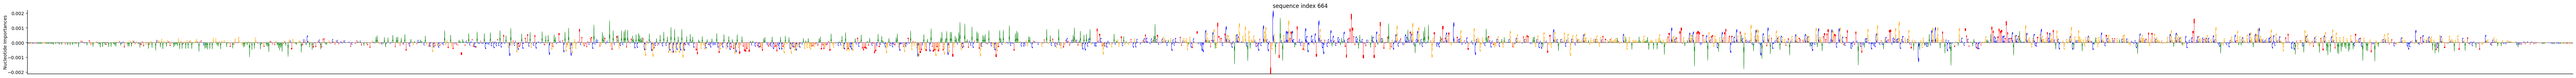

In [127]:
expl = x.cpu()*smoothed
expl = pd.DataFrame(expl[0])
expl = expl.T
expl.columns = ['A','C','G','T']
seq_df = expl

# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.title("sequence index "+str(i))
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
#plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".png",dpi=350,bbox_inches='tight',pad_inches=0)
#plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [129]:
import torch
import numpy as np

def compute_smoothgrad(model, x, target="reg", num_samples=50, noise=0.1):
    """
    Compute SmoothGrad explanations for a single input sequence.

    Parameters
    ----------
    model : torch.nn.Module
        Your trained model (with .eval() called).
    x : torch.Tensor
        Input tensor of shape (1, 4, L).
    target : str
        "reg" for regression output, "clf" for classification output.
    num_samples : int
        Number of noisy samples to average over.
    noise : float
        Standard deviation of Gaussian noise to apply to input.

    Returns
    -------
    numpy.ndarray
        Smoothed importance map of shape (L, 4).
    """
    model.eval()
    device = x.device
    x = x.detach().clone().to(device).requires_grad_(True)
    all_grads = []

    for _ in range(num_samples):
        noisy_x = x + noise * torch.randn_like(x)
        noisy_x = torch.clamp(noisy_x, 0, 1)  # keep within 0-1 for one-hot

        output = model(noisy_x)
        target_output = output[0] if target == "reg" else output[1]
        target_output = target_output.sum()

        model.zero_grad()
        target_output.backward(retain_graph=True)
        grad = noisy_x.grad.detach().clone()
        all_grads.append(grad * noisy_x)  # gradient × input

        noisy_x.grad = None

    avg_grad = torch.stack(all_grads).mean(dim=0)
    return avg_grad.squeeze(0).permute(1, 0).cpu().numpy()  # (L, 4)

In [133]:
def compute_smoothgrad(model, x, target="reg", num_samples=50, noise=0.1):
    """
    Compute SmoothGrad explanations for a single input sequence.

    Parameters
    ----------
    model : torch.nn.Module
        Your trained model (should already be .eval() and on correct device).
    x : torch.Tensor
        Input tensor of shape (1, 4, L). Should be on same device as model.
    target : str
        "reg" for regression output, "clf" for classification output.
    num_samples : int
        Number of noisy samples to average over.
    noise : float
        Standard deviation of Gaussian noise to apply to input.

    Returns
    -------
    numpy.ndarray
        Smoothed importance map of shape (L, 4).
    """
    device = next(model.parameters()).device
    model.eval()

    x = x.detach().clone().to(device).requires_grad_(True)
    all_grads = []

    for _ in range(num_samples):
        noisy_x = x + noise * torch.randn_like(x).to(device)
        noisy_x = torch.clamp(noisy_x, 0, 1).detach().clone().requires_grad_(True)

        output = model(noisy_x)
        target_output = output[0] if target == "reg" else output[1]
        target_output = target_output.sum()

        model.zero_grad()
        target_output.backward(retain_graph=True)

        grad = noisy_x.grad.detach().clone()
        all_grads.append(grad * noisy_x)

    avg_grad = torch.stack(all_grads).mean(dim=0)
    return avg_grad.squeeze(0).permute(1, 0).detach().cpu().numpy()  # shape (L, 4)

In [161]:
smooth_sal = compute_smoothgrad(model2, x, target="reg", num_samples=int(1e4), noise=0.15)

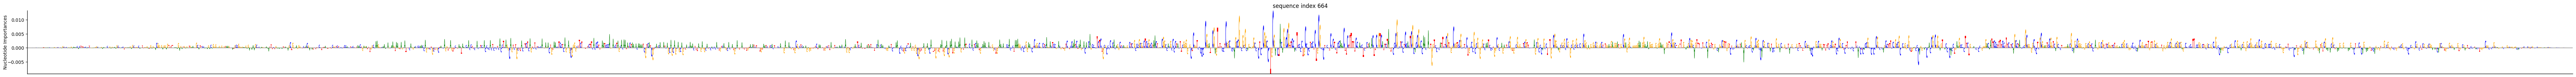

In [162]:
expl = x.cpu()[0]*smooth_sal.T
expl = pd.DataFrame(expl)
expl = expl.T
expl.columns = ['A','C','G','T']
seq_df = expl

# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.title("sequence index "+str(i))
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
#plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".png",dpi=350,bbox_inches='tight',pad_inches=0)
#plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [183]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logomaker
import numpy as np

def plot_filters_as_logos(
    model,
    top_k=5,
    ranking="l2",  # "l2" or "activation"
    input_seq=None,  # (1, 4, L) tensor (one-hot)
    layer_name="initial.0",  # name of first conv layer
    figsize=(10, 2.5)
):
    """
    Plot top-k first-layer convolutional filters from model as sequence logos.
    
    Parameters:
    - model: the PyTorch model
    - top_k: number of filters to show
    - ranking: "l2" or "activation"
    - input_seq: if ranking="activation", provide a one-hot encoded sequence (1, 4, L)
    - layer_name: name of the first conv layer (default: 'initial.0')
    - figsize: size per filter plot
    """
    conv_layer = dict(model.named_modules())[layer_name]
    weights = conv_layer.weight.detach().cpu()  # (out_channels, in_channels, kernel_size)
    num_filters = weights.shape[0]

    if ranking == "l2":
        norms = torch.norm(weights.view(num_filters, -1), dim=1)
        top_idx = torch.topk(norms, top_k).indices
    elif ranking == "activation":
        if input_seq is None:
            raise ValueError("You must provide input_seq for activation-based ranking.")
        with torch.no_grad():
            act = conv_layer(input_seq.to(next(model.parameters()).device))  # (1, F, L)
            act_mean = act.mean(dim=2).squeeze(0)  # (F,)
            top_idx = torch.topk(act_mean, top_k).indices.cpu()
    else:
        raise ValueError("ranking must be 'l2' or 'activation'")

    bases = ['A', 'C', 'G', 'T']
    for i, f_idx in enumerate(top_idx):
        w = weights[f_idx]  # shape (4, k)
        pwm = w.numpy().T  # shape (k, 4)
        pwm_df = pd.DataFrame(pwm, columns=bases)
        pwm_df = pwm_df.subtract(pwm_df.mean(axis=1), axis=0)

        logomaker.Logo(pwm_df, center_values=True, color_scheme='classic',figsize=figsize)

        plt.title(f'Filter {f_idx.item()} (rank {i+1})')
        plt.xlabel('Position')
        plt.ylabel('Weight')
        plt.show()

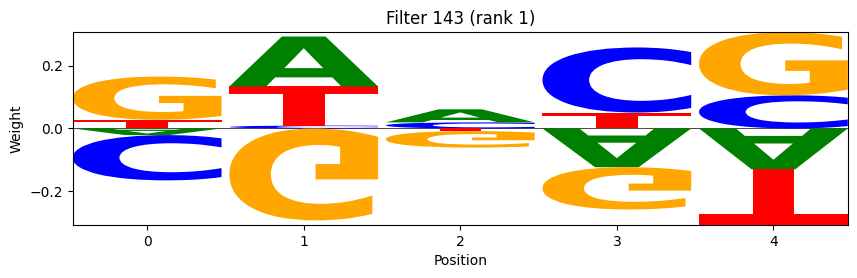

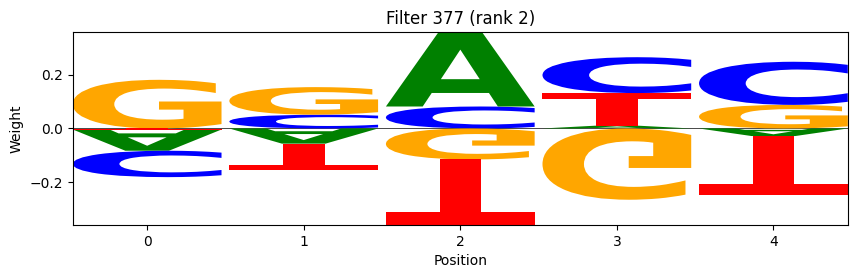

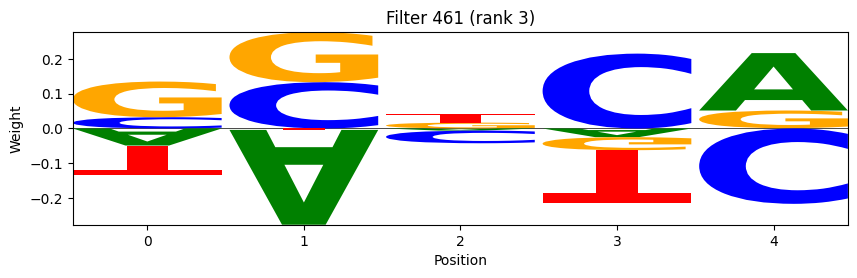

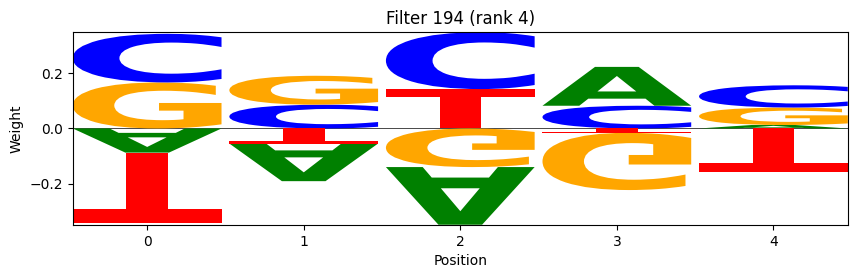

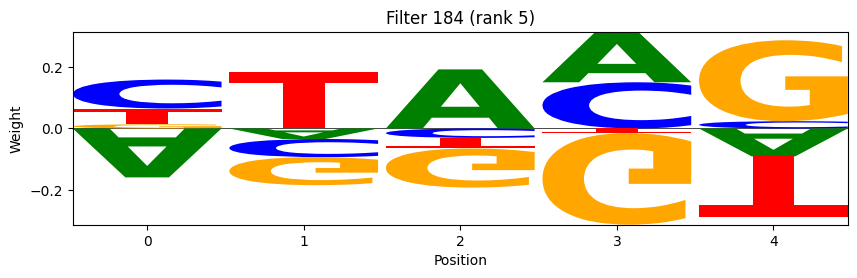

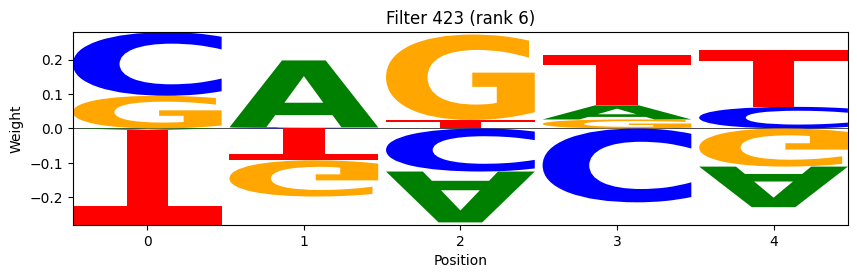

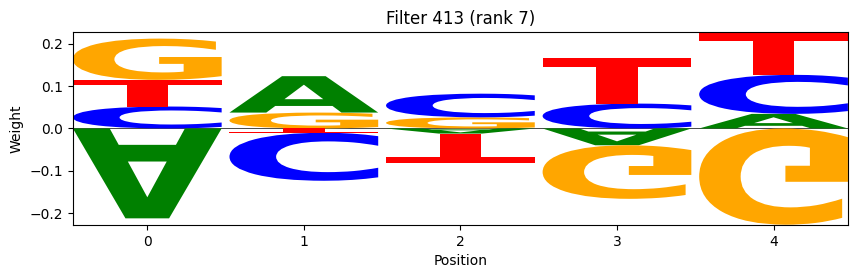

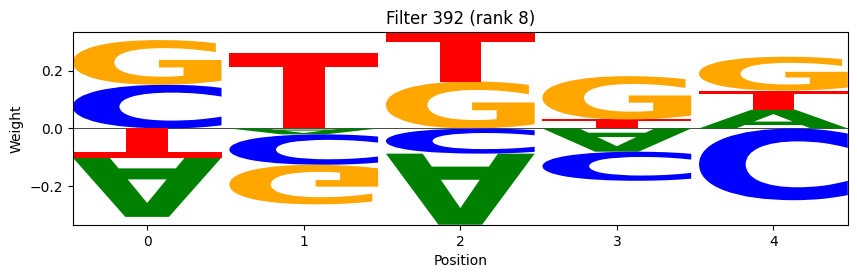

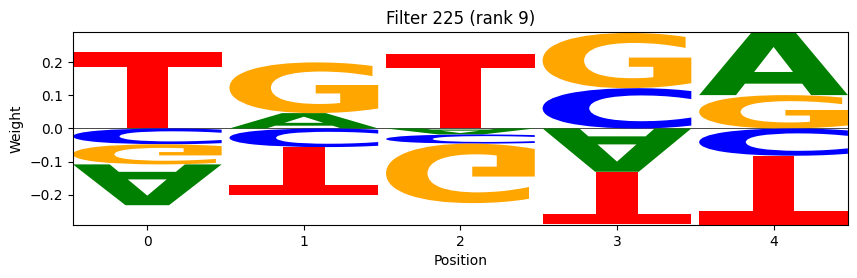

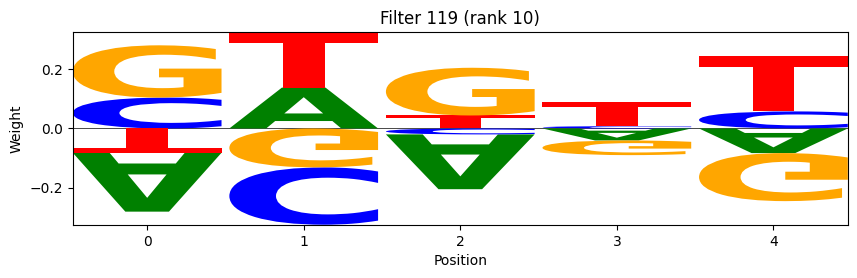

In [184]:
plot_filters_as_logos(model2, top_k=10, ranking="l2")

In [126]:
pd.DataFrame(smoothed)

0         1         2         3         4         5         6     \
0 -0.000085 -0.000085 -0.000086 -0.000087 -0.000083 -0.000086 -0.000087   
1 -0.000089 -0.000089 -0.000089 -0.000092 -0.000086 -0.000088 -0.000091   
2 -0.000086 -0.000086 -0.000082 -0.000088 -0.000084 -0.000078 -0.000085   
3 -0.000069 -0.000069 -0.000062 -0.000071 -0.000070 -0.000053 -0.000068   

       7         8         9     ...      2104      2105      2106      2107  \
0 -0.000074 -0.000086 -0.000090  ... -0.000092 -0.000087 -0.000073 -0.000088   
1 -0.000076 -0.000093 -0.000096  ... -0.000098 -0.000090 -0.000072 -0.000090   
2 -0.000080 -0.000091 -0.000090  ... -0.000089 -0.000084 -0.000075 -0.000083   
3 -0.000072 -0.000072 -0.000071  ... -0.000068 -0.000070 -0.000067 -0.000067   

       2108      2109      2110      2111      2112      2113  
0 -0.000083 -0.000087 -0.000086 -0.000086 -0.000086 -0.000085  
1 -0.000089 -0.000090 -0.000091 -0.000090 -0.000090 -0.000089  
2 -0.000086 -0.000080 -0.000087 -0.000083 -0.000086 -0.000086  
3 -0.000070 -0.000057 -0.000069 -0.000062 -0.000069 -0.000069  

[4 rows x 2114 columns]

In [73]:
import logomaker
import matplotlib.pyplot as plt
import pandas as pd

def plot_importance_logo(onehot_tensor, importance_tensor, figsize=(14, 3), title="Nucleotide Importance"):
    """
    Plot a sequence logo based on importance × onehot scores.

    Args:
        onehot_tensor (torch.Tensor): shape (1, 4, L)
        importance_tensor (torch.Tensor): shape (1, 4, L), e.g. saliency from gradient × input
        figsize (tuple): size of the figure
        title (str): title of the plot
    """
    # Convert tensors to numpy
    onehot = onehot_tensor.squeeze().cpu().numpy()      # shape: (4, L)
    importance = importance_tensor.squeeze().cpu().numpy()  # shape: (4, L)

    # Multiply onehot × importance
    weighted = onehot * importance

    # Create pandas dataframe
    df = pd.DataFrame(weighted.T, columns=["A", "C", "G", "T"])

    # Plot
    plt.figure(figsize=figsize)
    logomaker.Logo(df, color_scheme='classic')
    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

<Figure size 1400x300 with 0 Axes>

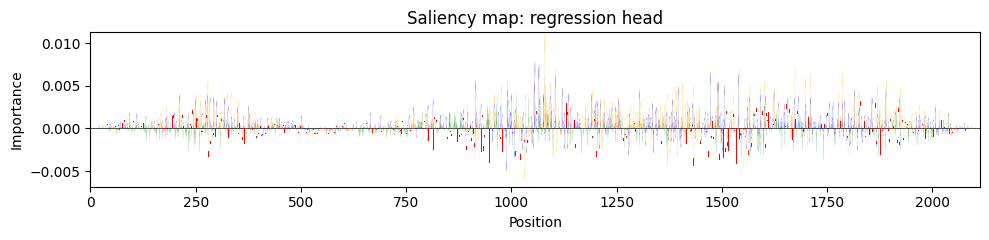

In [74]:
# Example usage
plot_importance_logo(x, saliency, title="Saliency map: regression head")

In [80]:
expl = x.cpu()*saliency.cpu()
expl = pd.DataFrame(expl[0])
expl = expl.T
expl.columns = ['A','C','G','T']
seq_df = expl

Test: 100%|██████████| 85/85 [00:44<00:00,  1.93it/s]

Test correlation: 0.781, Test accuracy: 1.000


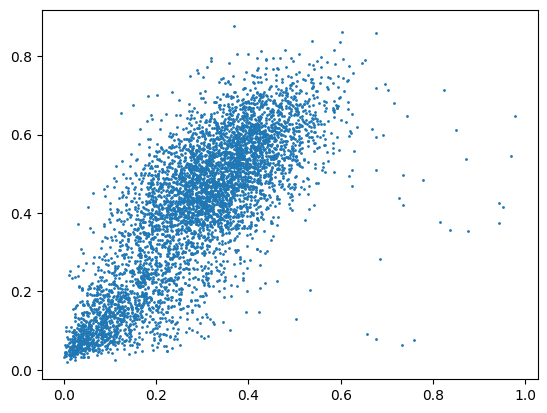

In [49]:
test_loader = DataLoader(ds_chimp_test, batch_size=64)
a2,b2,c2,d2 = evaluate_model(model, test_loader,return_vals=True)
plt.scatter(np.concatenate(a2).ravel(),np.concatenate(b2).ravel(),s=1)
plt.show()

Test: 100%|██████████| 85/85 [00:44<00:00,  1.93it/s]

Test correlation: 0.781, Test accuracy: 1.000


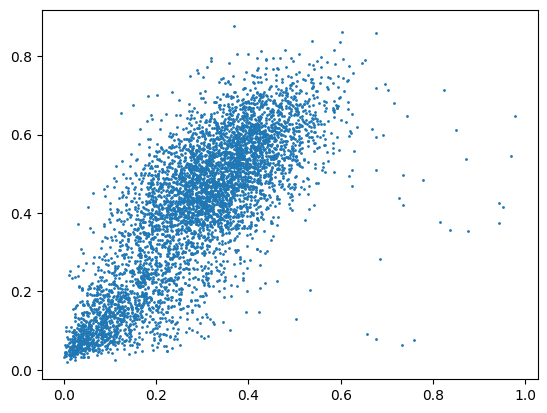

In [60]:
test_loader = DataLoader(ds_chimp_test, batch_size=64)
a2,b2,c2,d2 = evaluate_model(model2, test_loader,return_vals=True)
plt.scatter(np.concatenate(a2).ravel(),np.concatenate(b2).ravel(),s=1)
plt.show()

In [112]:
a2_series = pd.Series(np.concatenate(a2).ravel())

In [114]:
a2_series.sort_values()

4077    0.000908
85      0.001835
4012    0.002687
2484    0.003349
2558    0.003576
          ...   
1130    0.942214
2435    0.942687
2440    0.952564
2410    0.968874
1879    0.978184
Length: 5379, dtype: float32